# Data Analysis - (Statistics and plotting)
### Enrico Gavagnin

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import rpy2.robjects as robjects
import os
from matplotlib.patches import Rectangle
from rpy2.robjects.packages import importr
%load_ext rpy2.ipython

## Statistics (R)
R script which perform the LMER test for a given time window and exp

In [2]:
%%R 
rm(list=ls())
library(lme4)
library(car)

stats_R <- function() {
    
    # List of properties to use for the LMER test 
    # (the list should match the prop_list of python in the next cell)
    prop_list <- c('c3pMOD','wDIA','cwDEH','DEN', 'CLS')
    dat <- read.csv("NTM_df_stats.csv", header=T, stringsAsFactors = F)
    
    # list of properties for the LMER test
    pv_list <- integer(0)
    rf <- ' ~ exp +(1|rep)+(1|h)'
    
    for (prop in prop_list){
        model <- lmer(formula(paste(prop,rf)), data = dat)
        #print(summary(model))
        pv_list <- c(pv_list, as.numeric(Anova(model)["exp","Pr(>Chisq)"]))
    }

    pv_adj <- p.adjust(pv_list, method="BH")
    names(pv_adj) <- prop_list
  return(pv_adj)
}

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: carData



## Main script

This produces the final plots used in the Results Section of the manuscript.

1


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



2


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



3


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



4


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



6


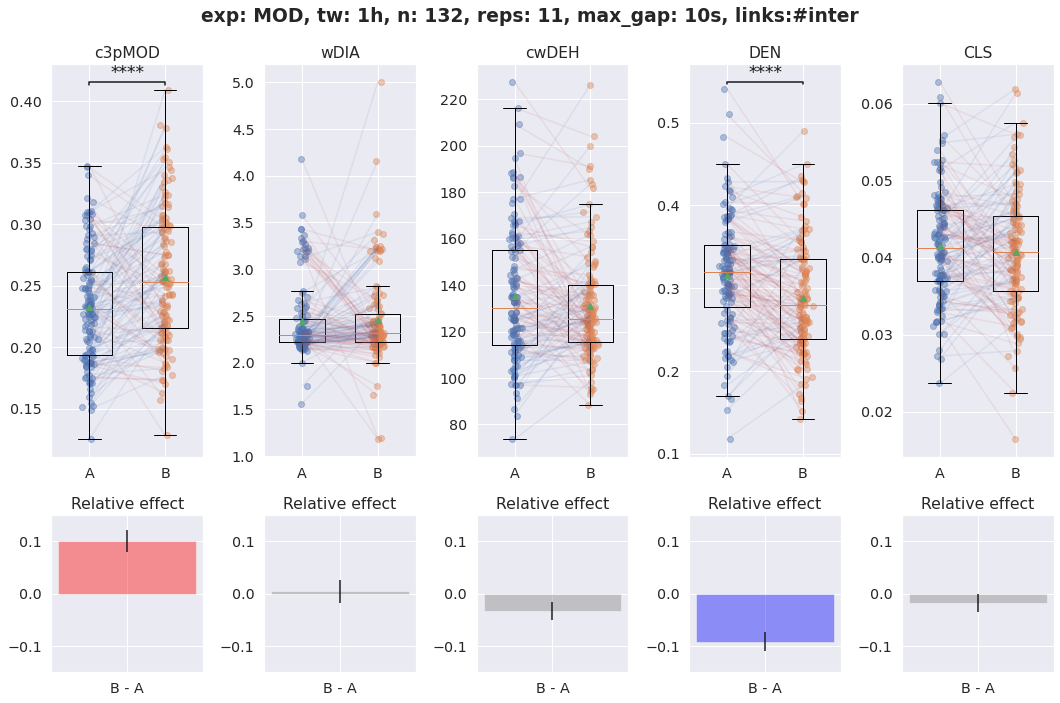

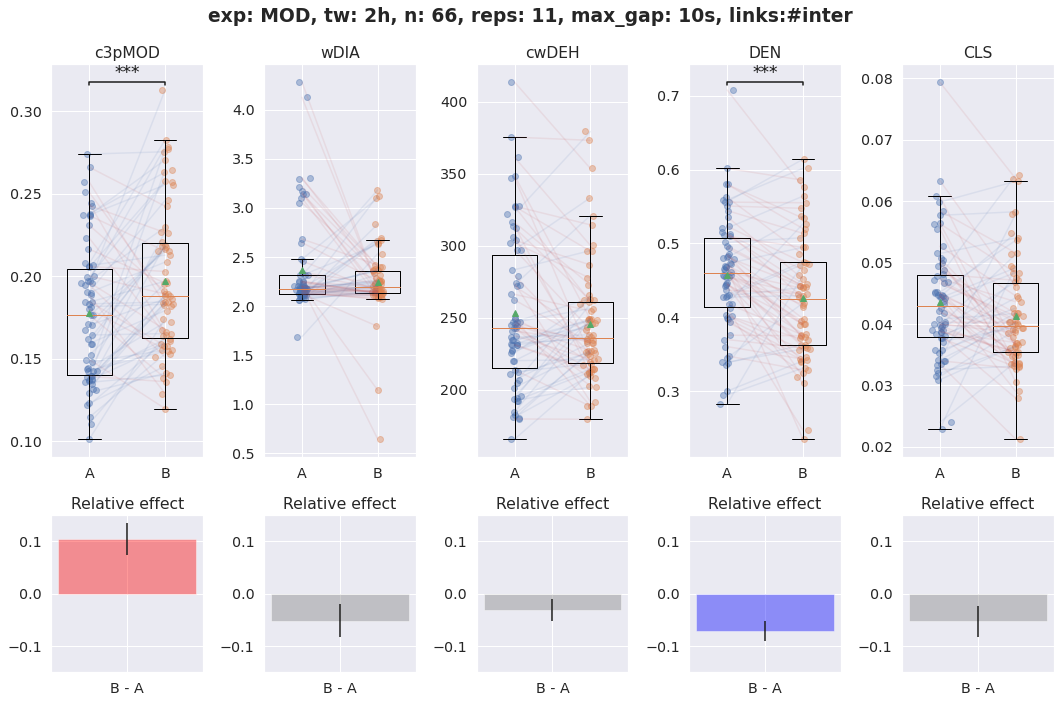

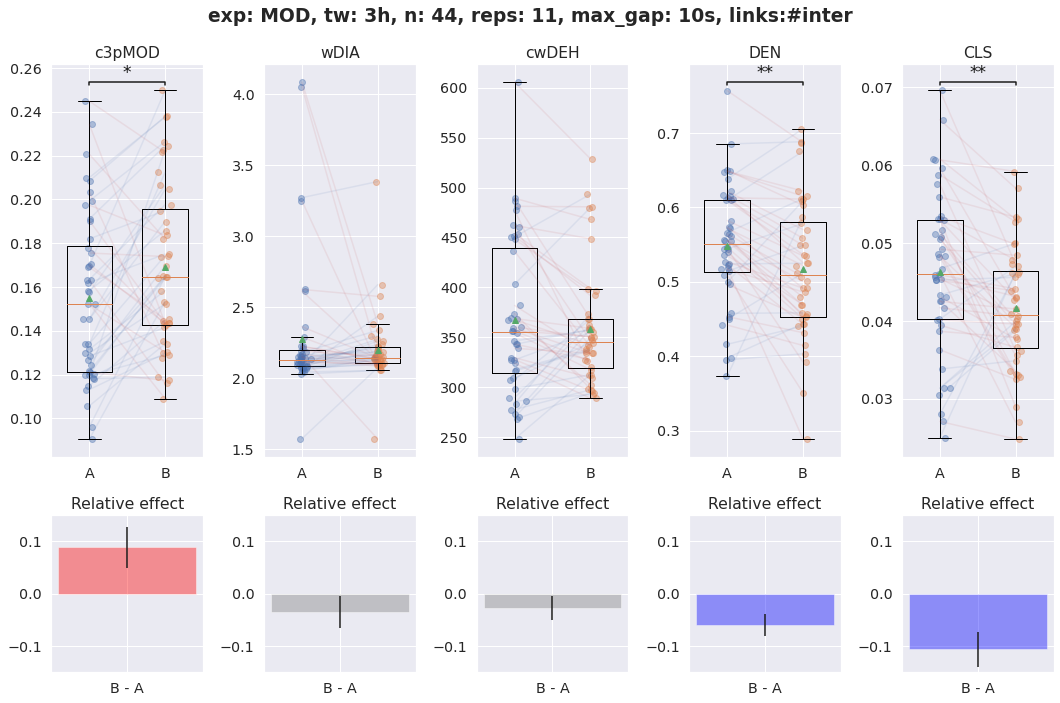

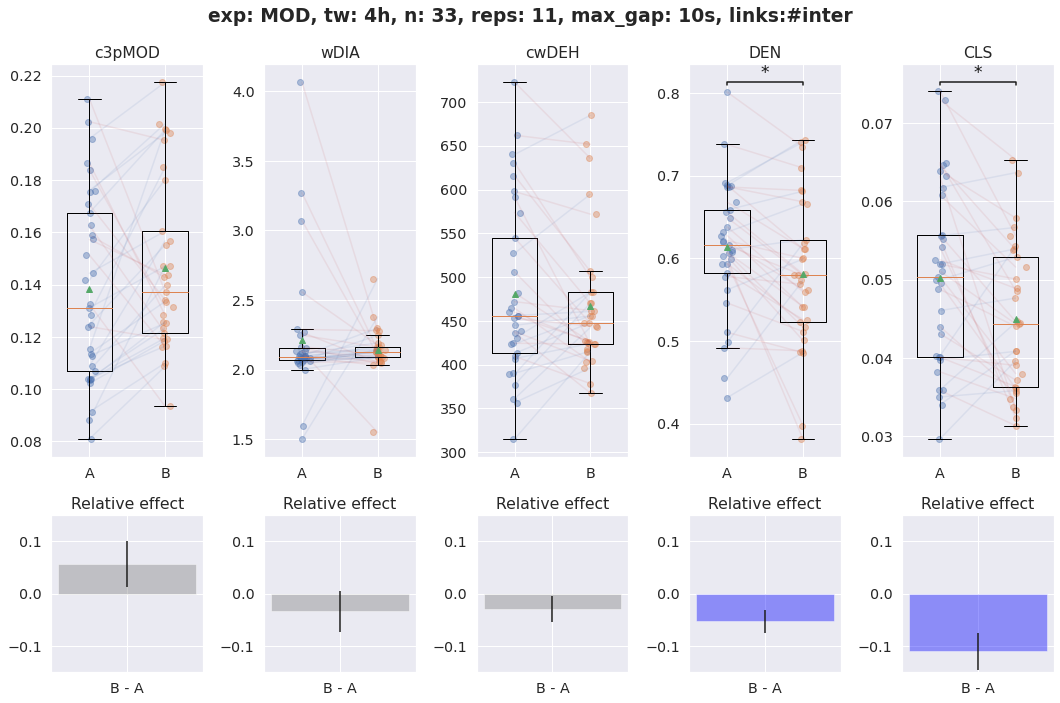

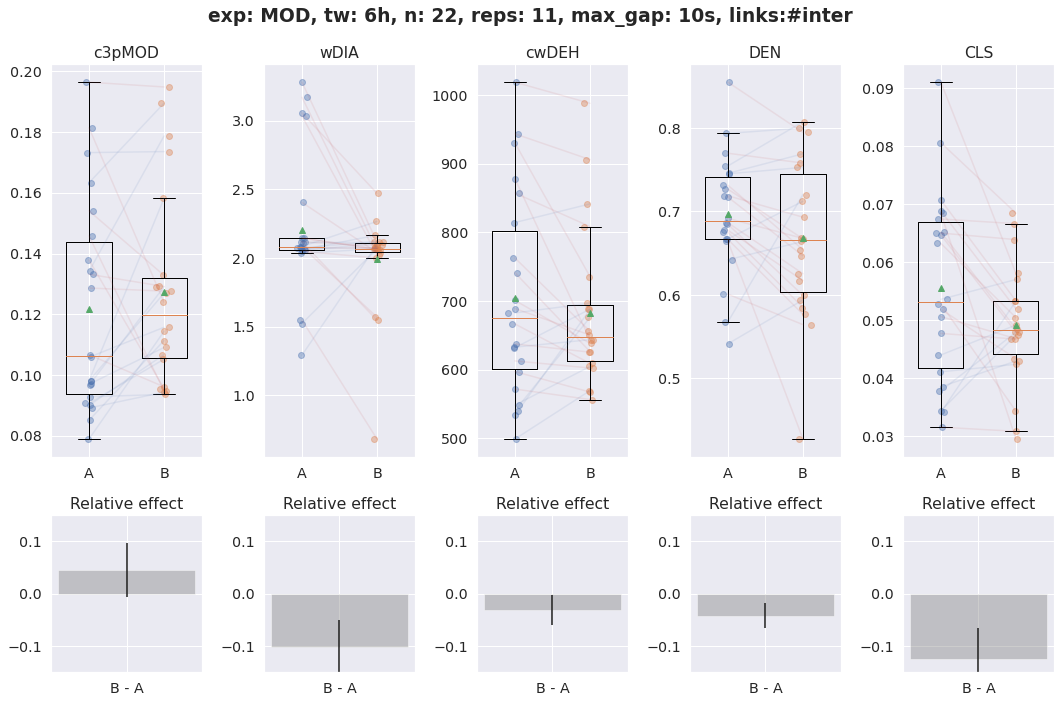

In [12]:
# ========== PARAMETERS ============

# Social network properties list
prop_list = ['c3pMOD','wDIA','cwDEH','DEN', 'CLS']

# Load pre-computed dataset of network properties (see Data_analysis_complete.ipynb)
data_file_name = 'data/prop_data_12_6_4_3_2_1_#inter_nest_21042022.pkl'

# Read link type from data file name
if '#inter_' in data_file_name:
    link_type = '#inter'
elif 'length_inter_'in data_file_name:
    link_type = 'length_inter'

# Replicates to be discarded
reps_discarded = [20,41]

# Total experimental window considered (h)
tot_win_h = 24

# maximum gap for interactions
max_gap = 10 #s


# Day/night focus ('day', 'night', 'day+night')
day_night = 'day'

# Down sample number of replicate to 5 replicates (Optional)
down_sample = False

# Conisder only interactions within the nest (Optional)
nest_focus = True




# Plots folder name (Create one if not existing)
plot_fld_path = 'plots/' + '_'.join(prop_list)  + '_' + day_night + '_NF_' + str(nest_focus) +'_' + link_type + '_DS_' + str(down_sample) + '/'
if not os.path.exists(plot_fld_path):
            os.makedirs(plot_fld_path)


# Load the condensation times record file 
cond_data = pd.read_excel('detection_data_export.xlsx').drop([0,1], axis=0).set_index('REPLICATE').iloc[:,21:-1]
cond_data = cond_data.rename(columns={c: c.hour for c in list(cond_data.columns)})

        
# Initialise summary dataframe
pv_effect_df = pd.DataFrame(columns=['exp', 'time_win (h)', 'link_type', 'pv/effect'] + prop_list)

# Load precomputed data 
df = pd.read_pickle(data_file_name)

# Loop through all the experiments 
for exp in ['MOD']:#, 'DIA', 'DEN', 'DEH']:

    # Loop through all time-window lengths (h)
    for time_win in [1, 2, 3, 4, 6]:
        
        print(time_win)

        
        # ========== FILTERING ============
        # Filter the row of the dataframe corresponding 
        # to the right experiment and time window length
        
        df_filt = df.loc[(df.time_win==3600 * time_win) &
                         (df.max_gap==max_gap) & 
                         (df.exp.isin([exp+'a',exp+'b'])) &
                         (~df.rep.isin(reps_discarded))]
        df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])

        # Apply day/night filter (if 'night+day' is selected no need to filter)
        if day_night == 'day':
            df_filt = df_filt.loc[(df_filt['h'] >= 9) & (df_filt['h'] + time_win <= 21)]
        elif day_night == 'night':
            df_filt = df_filt.loc[(df_filt['h'] + time_win <= 9) | (df_filt['h'] >= 21)]


        # Filter out the time slots with detected condensations, read from manually annotated file
        # (exclude also the corresponding time slot in the other experiemnt)
        df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'a', 
                                              [np.mod(df_filt.h.loc[idx] + h, 24) 
                                               for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                               ).sum() == 0 for idx in df_filt.index]]
        df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'b',
                                              [np.mod(df_filt.h.loc[idx] + h, 24) 
                                               for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                               ).sum() == 0 for idx in df_filt.index]]

        # Remove any overlapping time_window 
        # (sometimes needed if the pre-computed dataset included overlapping windows)
        df_filt = df_filt.loc[df_filt.h%time_win == 9%time_win]

        # Sort df_filt
        df_filt = df_filt.sort_values(['rep','h'])

        # Apply downsampling (Optional)
        if down_sample == True:
            df_filt = df_filt.loc[(df_filt.rep.isin(np.random.choice(df_filt.rep.unique(),5,replace=False)))]
       
        # CHECK that df matches the a-b structure
        if df_filt.rep.diff().iloc[1::2].sum() != 0:
            raise Exception('df_filt not having a-b strcture!')

        # Export dataframe for stats
        df_filt.to_csv('NTM_df_stats.csv')


        # ============ STATISTICS ============
        %R -o pv_adj pv_adj <- stats_R()


        # ============= PLOTTING =============
        pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}

        # Save p values on the summary dataframerme
        pv_dict['exp'] = exp
        pv_dict['time_win (h)'] = time_win
        pv_dict['link_type'] = link_type
        pv_dict['pv/effect'] = 'pv'
        pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(pv_dict, index=[0])], ignore_index=True)

        # Initialise picture
        fig, axs = plt.subplots(2, len(prop_list), 
                                gridspec_kw={'height_ratios': [2.5, 1]},
                                figsize=(15,10))
        
        # Initialise effect_dict (used for plotting summary of effect - next script)
        effect_dict = {}
        
        # Loop through all the social network properties considered
        for idx_p, p in enumerate(prop_list):
            
            # Reshape dataframe for NestA-NestB comparison
            df_ab = pd.DataFrame()
            
            # Adjust the nest labels so that the prediciton is always 
            # prop[NestA]>prop[NestB]
            
            if False: #exp in ['MOD', 'DEN']:   
                df_ab.insert(0, 'B', list(df_filt[p].iloc[::2]))
                df_ab.insert(1, 'A', list(df_filt[p].iloc[1::2]))
            else:
                df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
                df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
            
            
            
            # Compute property difference
            df_ab['B-A'] = df_ab.B-df_ab.A
            
            # ========== Box & Scatter Plots =============
            
            # preparing data (adding x-noise for scatter plot)
            vals, names, xs = [],[],[]
            for i, col in enumerate(['A', 'B']):
                vals.append(df_ab[col].values)
                names.append(col)
                # adds jitter to the data points
                xs.append(np.random.normal(i + 1, 0.04, df_ab[col].values.shape[0]))  

            # box plot
            box_plot = axs[0,idx_p].boxplot(vals, labels=names, showmeans=True, widths=0.6, showfliers=False)

            # scatter plot
            for x, val in zip(xs, vals):
                axs[0, idx_p].scatter(x, val, alpha=0.4)

            # step_line plot (datapoints pairwise comparison)
            for idx_step_line in range(len(df_ab)):
                axs[0, idx_p].plot([1, 2], [df_ab.A.iloc[idx_step_line], df_ab.B.iloc[idx_step_line]], alpha=0.1,
                                   color = 'r' if df_ab['B-A'].iloc[idx_step_line]<0 else 'b')

            # Compute mean and std
            means = df_ab.mean()
            stds =  df_ab.std()
            
            # Set title
            axs[0, idx_p].set_title(p)

            # Statistical significance
            if pv_dict[p]<=0.05:
                # Significance marker
                stat_sign = '*' + int(pv_dict[p]<=0.01) * '*' + int(pv_dict[p]<=0.001) * '*' + int(pv_dict[p]<=0.0001)*'*'
                        
                # Draw bracket of comparison with significance marker 
                x1, x2 = 1, 2   
                mm =np.max(df_ab.max())
                y, h, col = 1.01*mm, 0.005*mm, 'k'
                axs[0, idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                axs[0, idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=17)

            # Save relative effect (mean of deltas / total mean) - used for Summary plot of next script
            effect_dict[p] = df_ab['B-A'].mean() / pd.concat([df_ab['A'], df_ab['B']]).mean()
            effect_dict[p + '_std_error'] = df_ab['B-A'].std() / np.abs(pd.concat([df_ab['A'], df_ab['B']]).mean() * np.sqrt(len(df_ab)))

            # ========== Histogram relative effecct =========
            # Set color of histogram (Blue if meeting predicitons, red if not, gray if not significant)
            if effect_dict[p]>0:
                c = 'red'
            else:
                c = 'blue'
            if pv_dict[p]>=0.05:
                c = 'gray'
            
            axs[1, idx_p].bar([0], [effect_dict[p]], yerr= effect_dict[p + '_std_error'], alpha=0.4, color  = c)
            axs[1, idx_p].set_ylim([-0.15, 0.15])
            axs[1, idx_p].set_title('Relative effect')
            axs[1, idx_p].set_xticks([0],['B - A'])
            plt.tight_layout()

        # Save effects on the summary dataframe
        effect_dict['exp'] = exp
        effect_dict['time_win (h)'] = time_win
        effect_dict['link_type'] = link_type
        effect_dict['pv/effect'] = 'effect'
        pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(effect_dict, index=[0])], ignore_index=True)

        # Visual adjustments
        title = 'exp: ' + exp + ', tw: ' + str(time_win) + 'h' + ', n: ' + str(len(df_ab)) + ', reps: ' + str(len(df_filt.rep.unique())) +  ', max_gap: ' + str(max_gap) + 's, links:' + link_type
        file_name = 'dist_comp_exp_' + exp + '_tw_' + str(time_win) + '_links_' + link_type
        fig = plt.suptitle(title, fontweight="bold")
        plt.tight_layout()
        plt.savefig(plot_fld_path + file_name + '.png', facecolor='white', transparent=False)
        #plt.close()

# Export dataframe for stats
pv_effect_df.to_csv('data/pv_effect_df.csv')


## Effect summary heatmaps

In [11]:
df_filt

rep   exp                start time_win   h max_gap   GC ants  \
162   14  MODa  2021-09-13 09:00:00    21600   9      10  161  176   
218   14  MODb  2021-09-11 09:00:00    21600   9      10  183  185   
163   14  MODa  2021-09-13 15:00:00    21600  15      10  172  176   
219   14  MODb  2021-09-11 15:00:00    21600  15      10  183  185   
498   17  MODa  2021-10-01 09:00:00    21600   9      10  185  189   
554   17  MODb  2021-10-03 09:00:00    21600   9      10  178  179   
499   17  MODa  2021-10-01 15:00:00    21600  15      10  187  189   
555   17  MODb  2021-10-03 15:00:00    21600  15      10  177  179   
1058  22  MODa  2021-10-11 09:00:00    21600   9      10  175  180   
1114  22  MODb  2021-10-09 09:00:00    21600   9      10  169  177   
1059  22  MODa  2021-10-11 15:00:00    21600  15      10  175  180   
1115  22  MODb  2021-10-09 15:00:00    21600  15      10  163  177   
1618  27  MODa  2021-10-17 09:00:00    21600   9      10  172  185   
1674  27  MODb  2021-10-19 09:00:00    21600   9      10  164  184   
1619  27  MODa  2021-10-17 15:00:00    21600  15      10  172  185   
1675  27  MODb  2021-10-19 15:00:00    21600  15      10  153  184   
1954  30  MODa  2021-10-25 09:00:00    21600   9      10  166  171   
2010  30  MODb  2021-10-23 09:00:00    21600   9      10  174  177   
1955  30  MODa  2021-10-25 15:00:00    21600  15      10  164  171   
2011  30  MODb  2021-10-23 15:00:00    21600  15      10  172  177   
2290  33  MODa  2021-11-12 09:00:00    21600   9      10  159  165   
2346  33  MODb  2021-11-14 09:00:00    21600   9      10  159  163   
2291  33  MODa  2021-11-12 15:00:00    21600  15      10  160  165   
2347  33  MODb  2021-11-14 15:00:00    21600  15      10  157  163   
3074  40  MODa  2021-11-24 09:00:00    21600   9      10  172  179   
3130  40  MODb  2021-11-22 09:00:00    21600   9      10  170  178   
3075  40  MODa  2021-11-24 15:00:00    21600  15      10  173  179   
3131  40  MODb  2021-11-22 15:00:00    21600  15      10  172  178   
3410  44  MODa  2021-11-29 09:00:00    21600   9      10  162  169   
3466  44  MODb  2021-12-01 09:00:00    21600   9      10  163  167   
3411  44  MODa  2021-11-29 15:00:00    21600  15      10  166  169   
3467  44  MODb  2021-12-01 15:00:00    21600  15      10  160  167   
3858  48  MODa  2021-12-08 09:00:00    21600   9      10  157  162   
3914  48  MODb  2021-12-06 09:00:00    21600   9      10  160  171   
3859  48  MODa  2021-12-08 15:00:00    21600  15      10  157  162   
3915  48  MODb  2021-12-06 15:00:00    21600  15      10  165  171   
3970  49  MODa  2021-12-10 09:00:00    21600   9      10  166  169   
4026  49  MODb  2021-12-12 09:00:00    21600   9      10  155  162   
3971  49  MODa  2021-12-10 15:00:00    21600  15      10  161  169   
4027  49  MODb  2021-12-12 15:00:00    21600  15      10  155  162   
4530  54  MODa  2021-12-20 09:00:00    21600   9      10  158  158   
4586  54  MODb  2021-12-18 09:00:00    21600   9      10  162  162   
4531  54  MODa  2021-12-20 15:00:00    21600  15      10  155  158   
4587  54  MODb  2021-12-18 15:00:00    21600  15      10  160  162   

                  cMOD_communities cmpMOD_communities  ...      wDEN DIA  \
162               [49, 50, 19, 43]   [79, 41, 21, 20]  ...  0.000197   3   
218               [27, 42, 64, 50]   [60, 57, 48, 18]  ...  0.000215   3   
163          [13, 21, 20, 16, 102]  [103, 38, 19, 12]  ...  0.000206   4   
219           [42, 34, 42, 24, 41]   [67, 60, 46, 10]  ...  0.000291   3   
498                   [95, 74, 16]    [108, 75, 1, 1]  ...  0.000347   3   
554                   [96, 13, 69]    [97, 66, 14, 1]  ...  0.000341   3   
499                  [41, 104, 42]   [112, 59, 15, 1]  ...  0.000383   3   
555                  [27, 48, 102]    [95, 47, 34, 1]  ...  0.000386   3   
1058              [43, 35, 51, 46]   [51, 50, 38, 36]  ...  0.000278   5   
1114              [51, 48, 44, 26]    [66, 57, 44, 2]  ...   0.00025   3   
1059          [15,

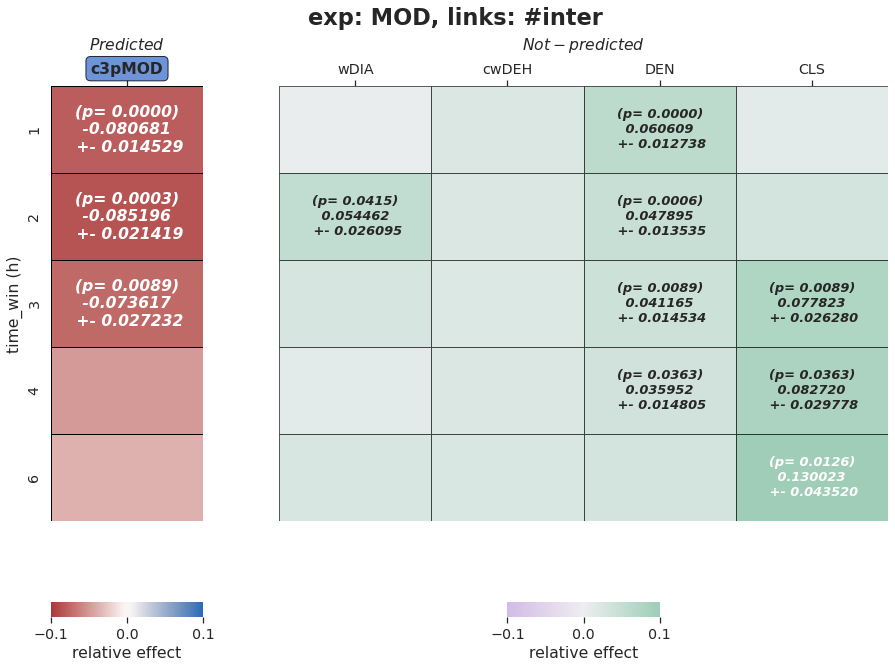

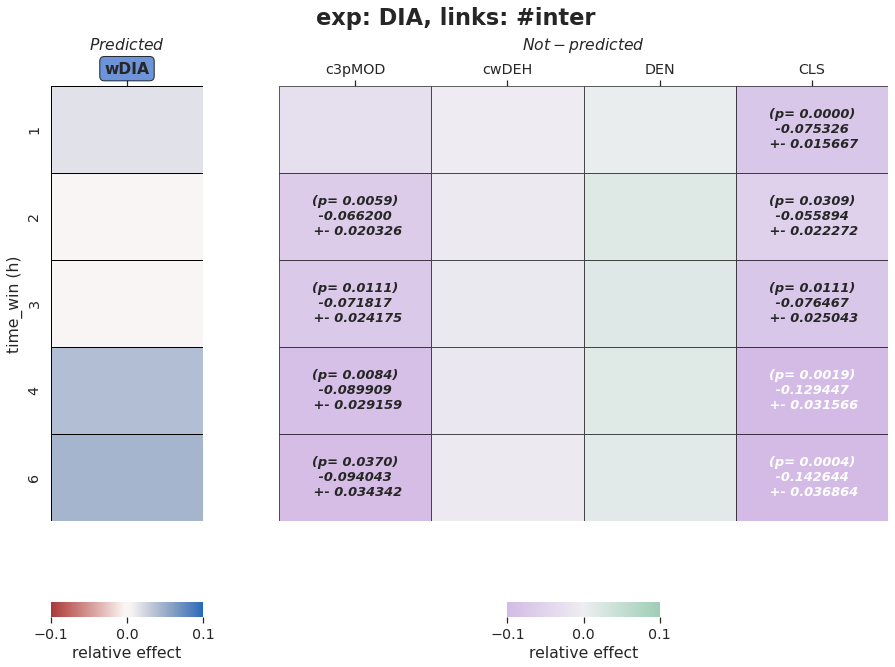

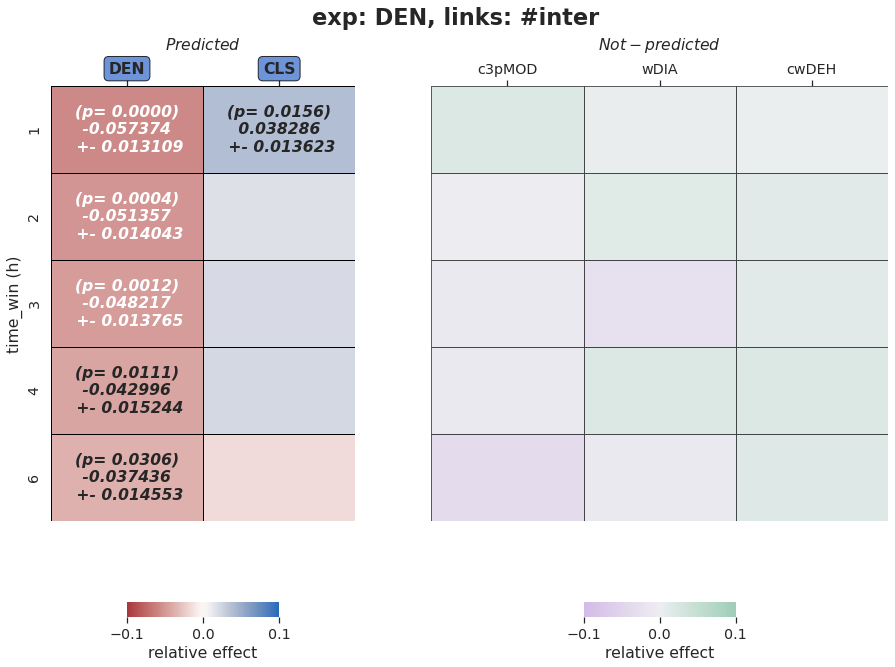

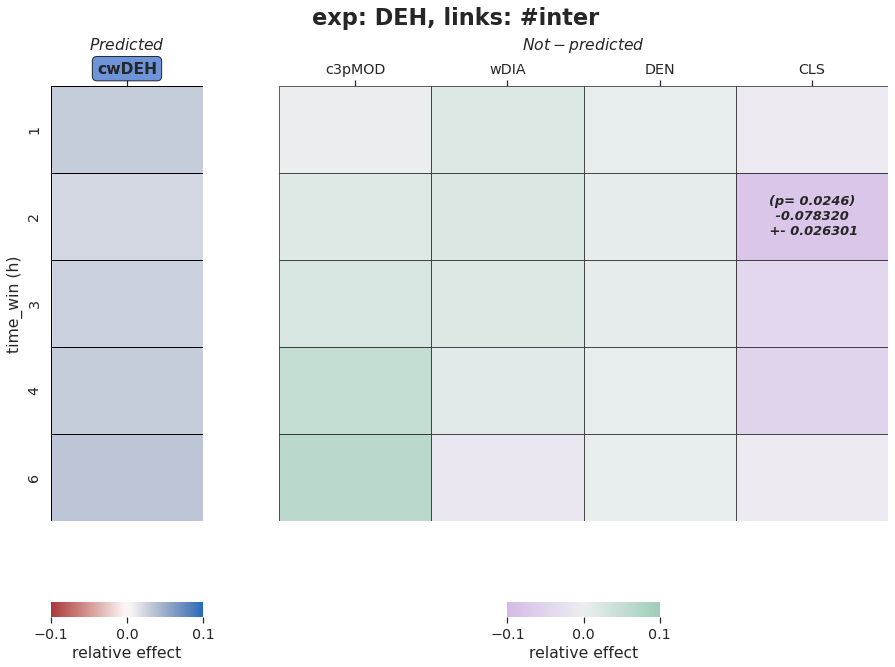

In [4]:
# ============== PLOTTING EFFECT SUMMARY ===============

pv_effect_df = df = pd.read_csv('data/pv_effect_df.csv', index_col=0)

# Loop throught experiments 
for exp in ['MOD', 'DIA', 'DEN', 'DEH']:

    # Read data with relative effect, pvalues and standard errors
    pv_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                         (pv_effect_df['pv/effect'] == 'pv') & 
                         (pv_effect_df['link_type'] == link_type)].set_index('time_win (h)')[prop_list]

    effect_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                             (pv_effect_df['pv/effect'] == 'effect') & 
                             (pv_effect_df['link_type'] == link_type)].set_index('time_win (h)')[prop_list]

    effect_std_error_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                                       (pv_effect_df['pv/effect'] == 'effect') & 
                                       (pv_effect_df['link_type'] == link_type)].set_index('time_win (h)')[[prop + '_std_error' for prop in prop_list]]

    # Text annotation to fill the heatmap (only for significant values)
    sns.set(font_scale = 1.3)
    annot = pv_df.copy()
    for i in range(np.shape(annot)[0]):
        for j in range(np.shape(annot)[1]):
            annot.iloc[i,j] = '(p= {:.4f})\n {:f} \n +- {:f}'.format(annot.iloc[i,j], effect_df.iloc[i,j], effect_std_error_df.iloc[i,j])
    annot[pv_df>0.05] = ''
    
    # Sort the columns to have thosewith predictions on the right-hand side
    cols = pv_df.columns.tolist()
    cols_pred = [c for c in cols if exp in c] 
    if exp == 'DEN':
        cols_pred += ['CLS']
    cols_nopred = [c for c in cols if c not in cols_pred]

    # Initialise figure
    fig, axs = plt.subplots(1, 2, 
                            gridspec_kw={'width_ratios': [len(cols_pred), len(cols_nopred)]},
                            figsize=(15,10))

    # =========== HEATMAP ============
    # Properties with prediciton
    sns.heatmap(effect_df[cols_pred], linewidths=1,
                linecolor='black',
                ax = axs[0],
                cmap="vlag_r",
                center=0,
                vmin=-0.1,
                annot_kws={"style": "italic", "weight": "bold"},
                vmax=0.1,
                annot = annot[cols_pred], fmt = '',
                cbar_kws={'label': 'relative effect', 
                    'location':"bottom", 
                    'aspect': 10,
                    "shrink": 1/len(cols_pred),
                    'fraction': 0.05,
                    'ticks': [-0.1, 0, 0.1]})

    # Visual adjustments
    axs[0].xaxis.tick_top()
    axs[0].xaxis.set_label_position('top')
    axs[0].set_title('$\it{Predicted}$', y=1.07)      
    bbox = dict(boxstyle="round", ec="black", fc=sns.color_palette('muted')[0], alpha=0.8)
    plt.setp(axs[0].get_xticklabels(), bbox=bbox, fontweight="bold", fontsize='medium')

    # Properties with no prediciton
    sns.heatmap(effect_df[cols_nopred], linewidths=1,
                linecolor='black',
                ax = axs[1],
                cmap=sns.diverging_palette(290, 145, s=60, l=70, as_cmap=True),
                center=0,
                vmin=-0.1,
                vmax=0.1,
                alpha=0.6,
                annot_kws={"style": "italic", "weight": "bold", 'fontsize': 'small'},
                annot = annot[cols_nopred], fmt = '',
                cbar_kws={'label': 'relative effect', 
                    'location':"bottom", 
                    'aspect': 10,
                    "shrink": 1/len(cols_nopred),
                    'fraction': 0.05,
                    'ticks': [-0.1, 0, 0.1]})

    # Visual adjustments
    axs[1].xaxis.tick_top()
    axs[1].xaxis.set_label_position('top')
    axs[1].set_ylabel('')
    axs[1].set_title('$\it{Not-predicted}$',y=1.07)
    axs[1].set_yticks([])

    # Title and save
    title = 'exp: ' + exp + ', links: ' + link_type
    file_name = 'stats_summary_exp_' + exp + '_link type_' + link_type
    fig = plt.suptitle(title, fontweight="bold", y =0.99, fontsize='x-large')
    plt.savefig(plot_fld_path + file_name + '.png', facecolor='white', transparent=False)
    #plt.close()